In [11]:
# Add DEVENV_PATH to the path so that we can import the modules
import sys
from os import getenv
import numpy as np
sys.path.append(getenv("DEVENV_ROOT"))
import pendulum

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import greenflow.analysis as an
from entrypoint import load_gin
from greenflow.utils import convert_to_mib

cutoff = "2024-12-16T03:15:35.626996+01:00"
cutoff_end = "2025-01-06T03:15:35.626996+01:00"

load_gin(exp_name="ingest-kafka", test=False)

cutoff_end = pendulum.now().to_iso8601_string()

cutoff_end

'2025-01-29T17:11:17.969185+01:00'

In [20]:
def safety_analysis(data):
    def _safety(data, system_name):
        plt.figure(figsize=(12, 7))
        
        # Create the boxplot
        ax = sns.boxplot(x='messageSize', y='observed_throughput', data=data)
        
        # Calculate median values for each message size
        medians = data.groupby('messageSize')['observed_throughput'].median()
        
        # Add annotations for median values
        for i, median in enumerate(medians):
            ax.text(i, median, f'{int(median):,}',
                   horizontalalignment='center',
                   verticalalignment='bottom',
                   fontsize=9,
                   bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

        plt.title(f'Message Size vs Throughput Distribution for {system_name}')
        plt.xlabel('Message Size (bytes)')
        plt.ylabel('Message Rate (messages/sec)')
        
        # Rotate x-axis labels
        plt.xticks(rotation=45)
        
        # Add grid for better readability
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

    # Create plots for both systems
    kafka_data = data[data["exp_name"] == "ingest-kafka"]
    redpanda_data = data[data["exp_name"] == "ingest-redpanda"]
    
    _safety(kafka_data, "Kafka")
    _safety(redpanda_data, "Redpanda")


In [12]:
common = dict(type="safetyCurve", cutoff_begin=cutoff, cutoff_end=cutoff_end, partitions=1)
grappe_1 = an.full_analytical_pipeline(cluster="grappe", **common)
ovhnvme_1 = an.full_analytical_pipeline(cluster="ovhnvme", **common)
taurus_1 = an.full_analytical_pipeline(cluster="taurus", **common)

In [4]:
# common = dict(type="safetyCurve", cutoff_begin=cutoff, cutoff_end=cutoff_end, partitions=1)
# grappe_1 = an.full_analytical_pipeline_nocache(cluster="grappe", **common)
# ovhnvme_1 = an.full_analytical_pipeline_nocache(cluster="ovhnvme", **common)
# taurus_1 = an.full_analytical_pipeline_nocache(cluster="taurus", **common)

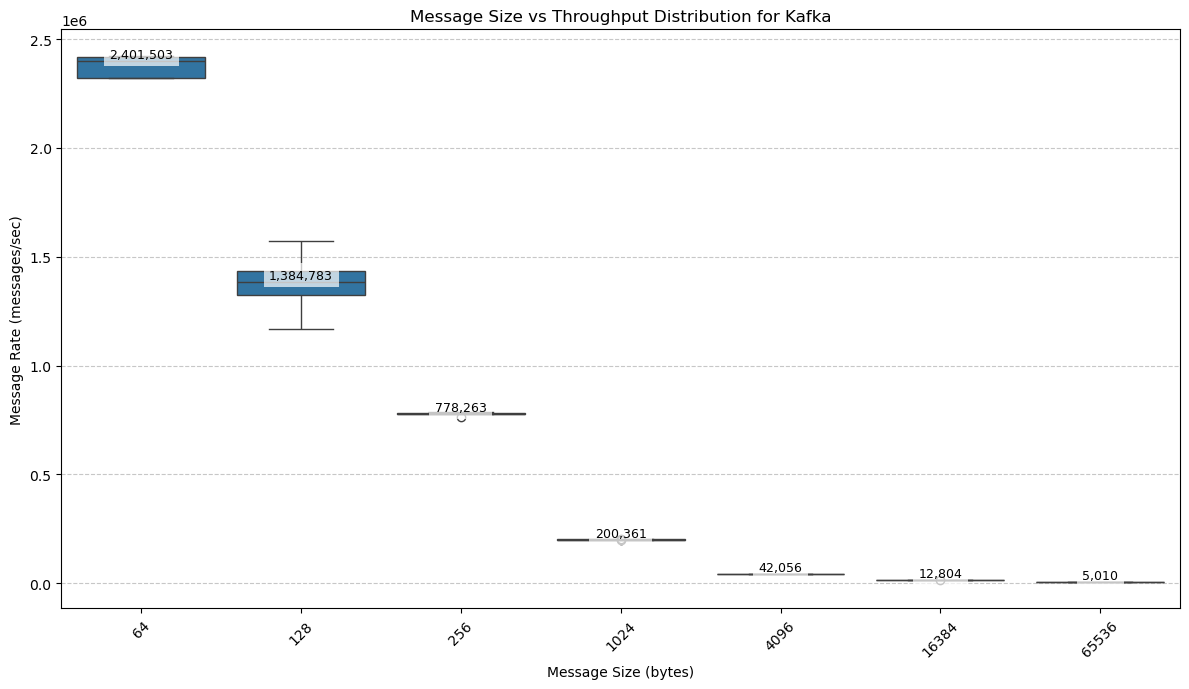

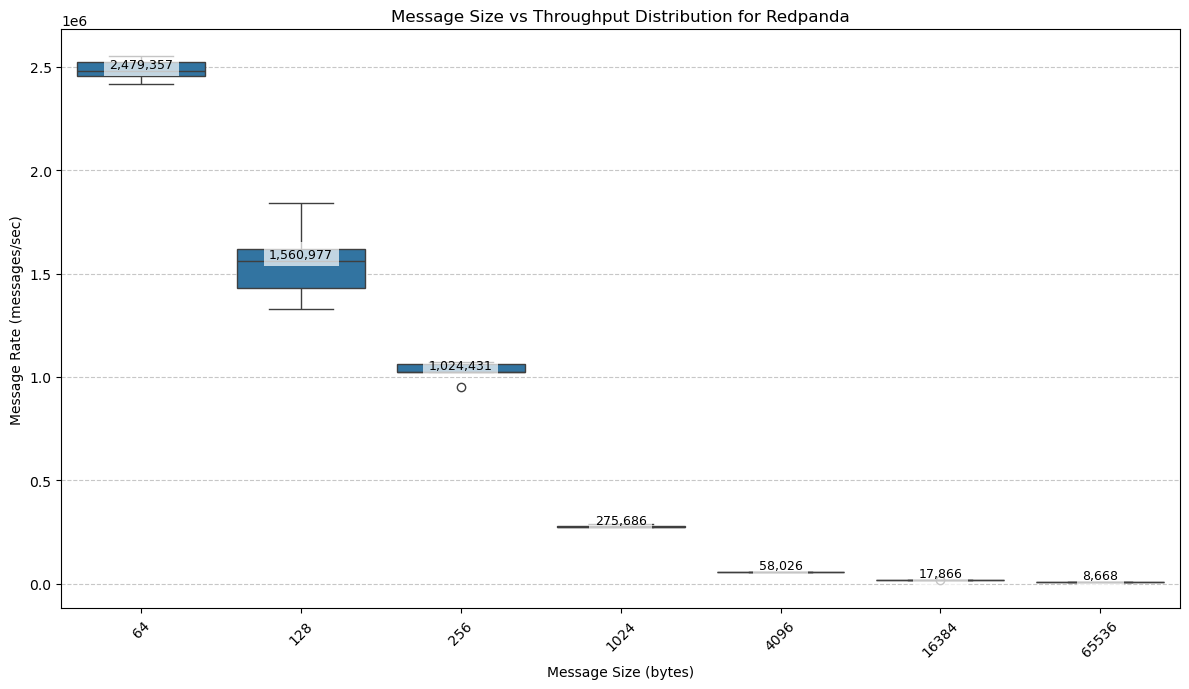

In [21]:
safety_analysis(ovhnvme_1)

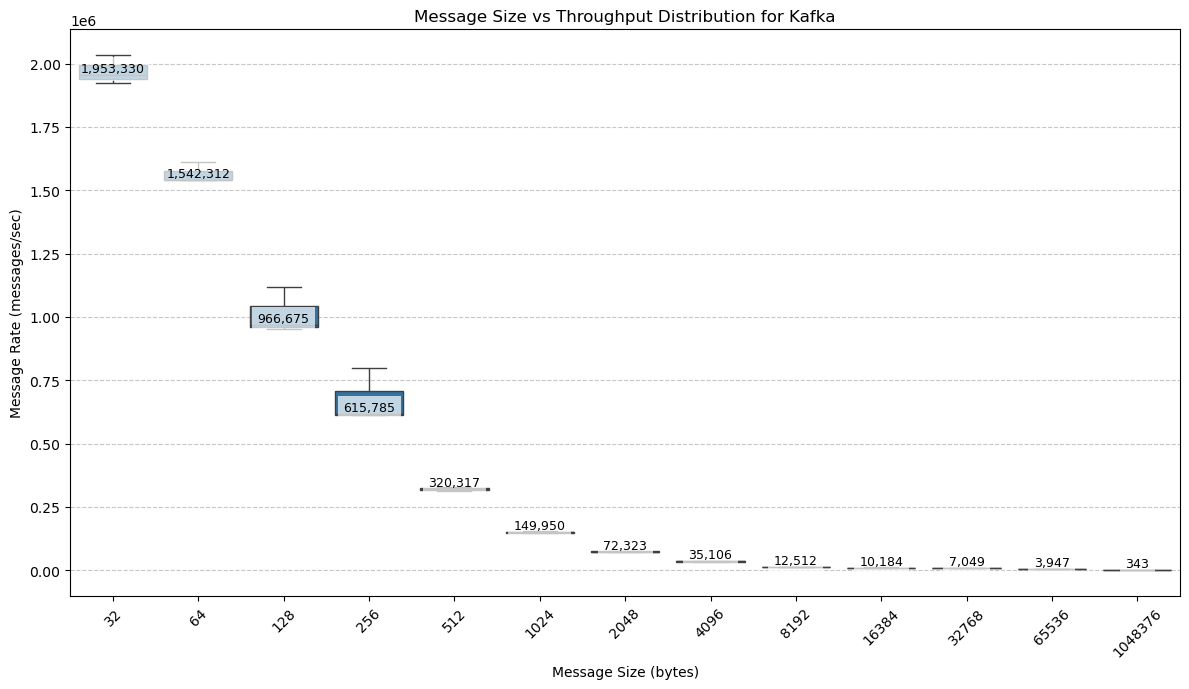

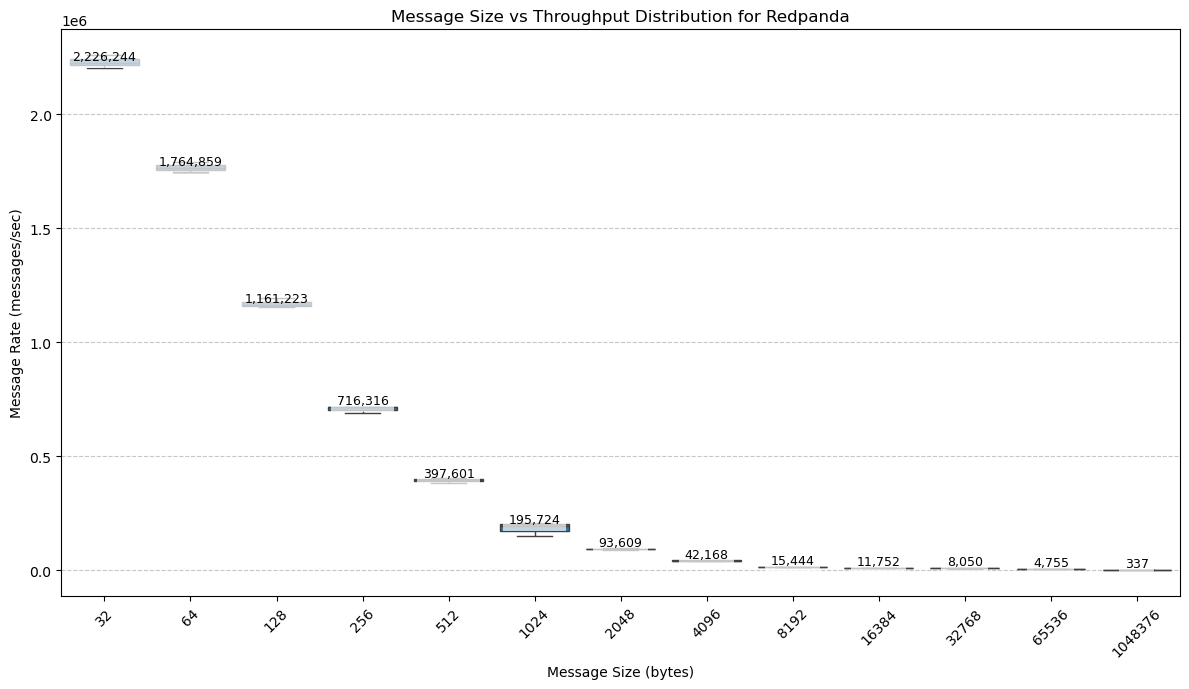

In [22]:
safety_analysis(grappe_1)

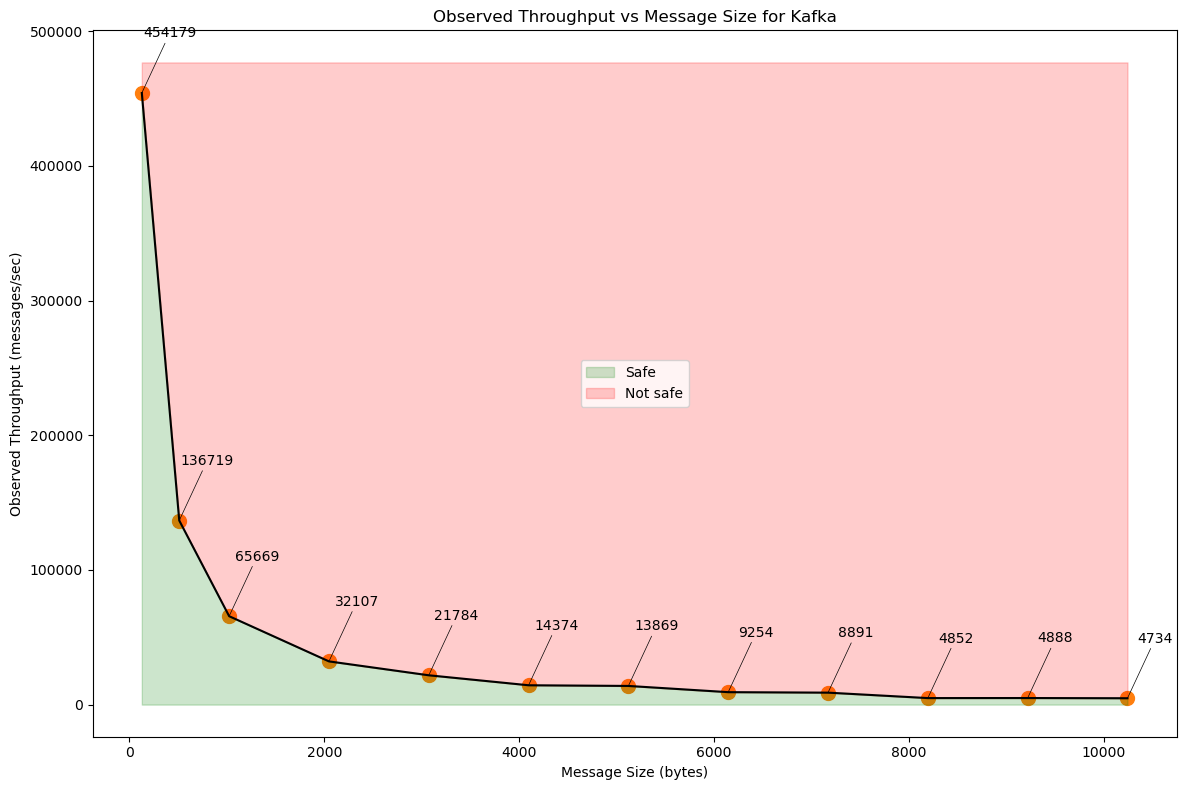

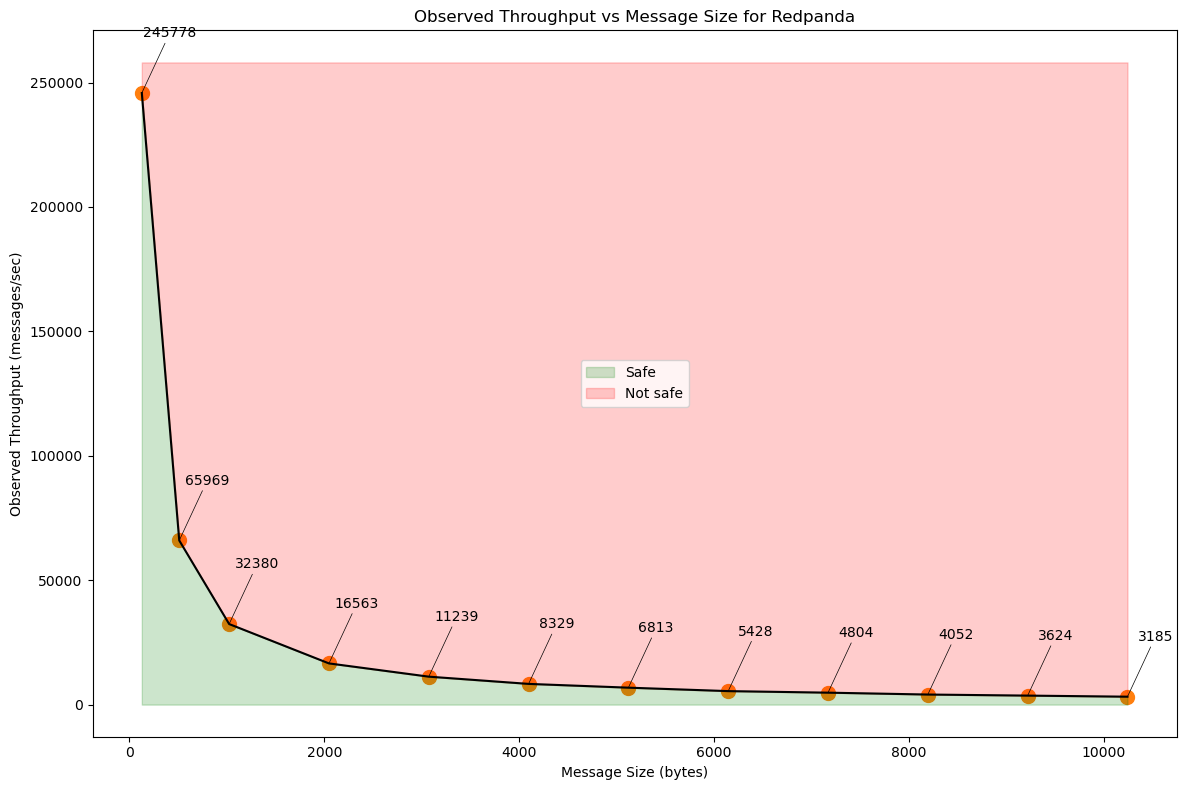

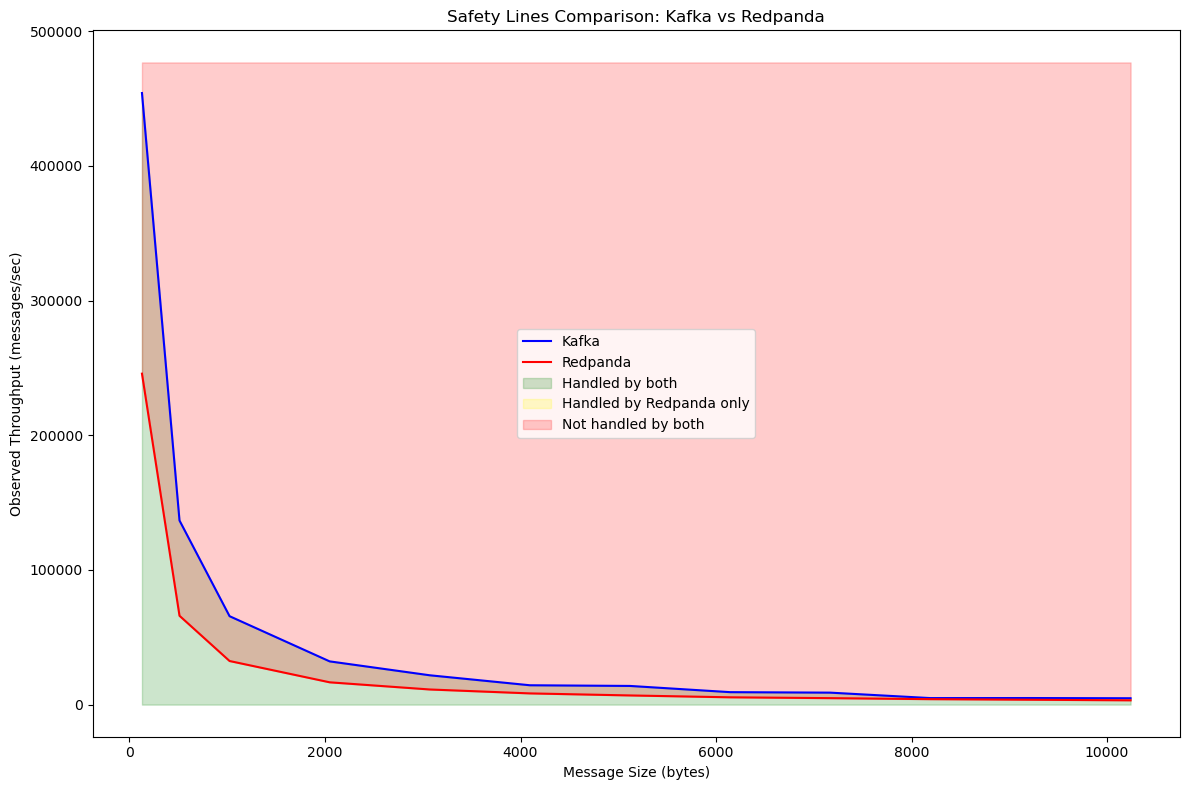

In [7]:
safety_analysis(taurus_1)

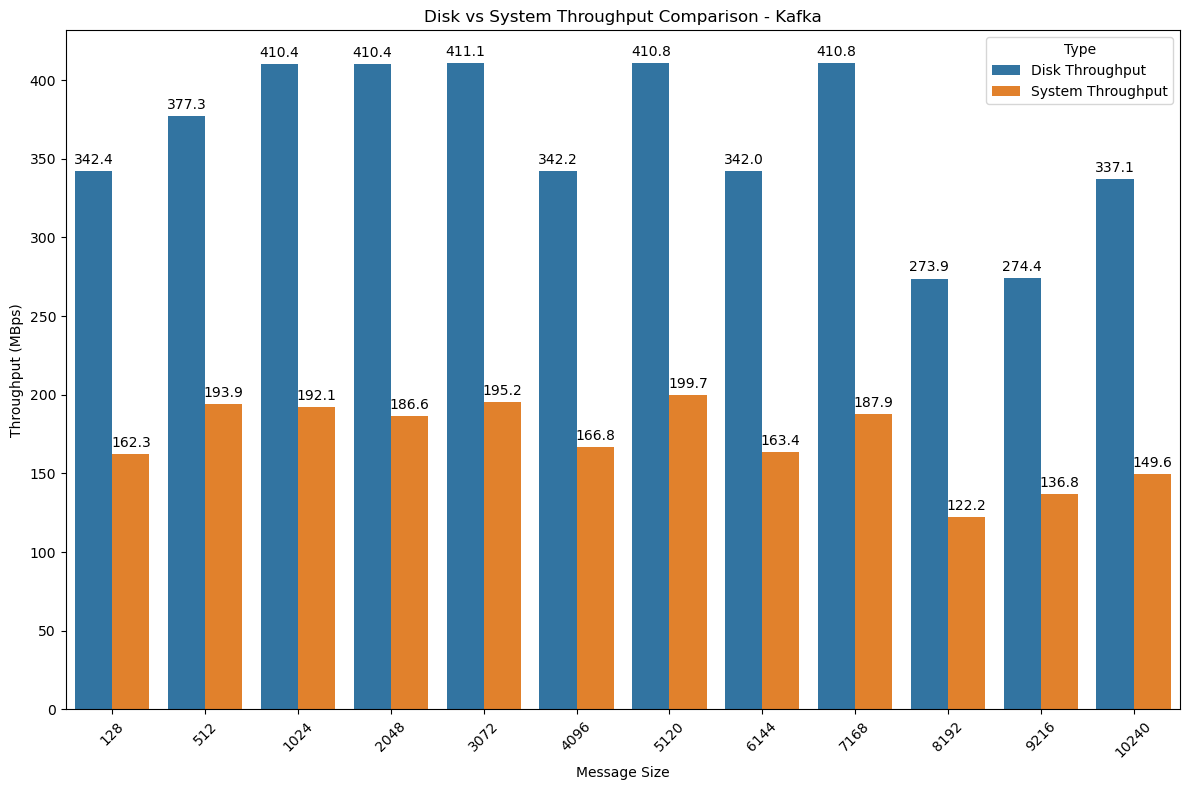

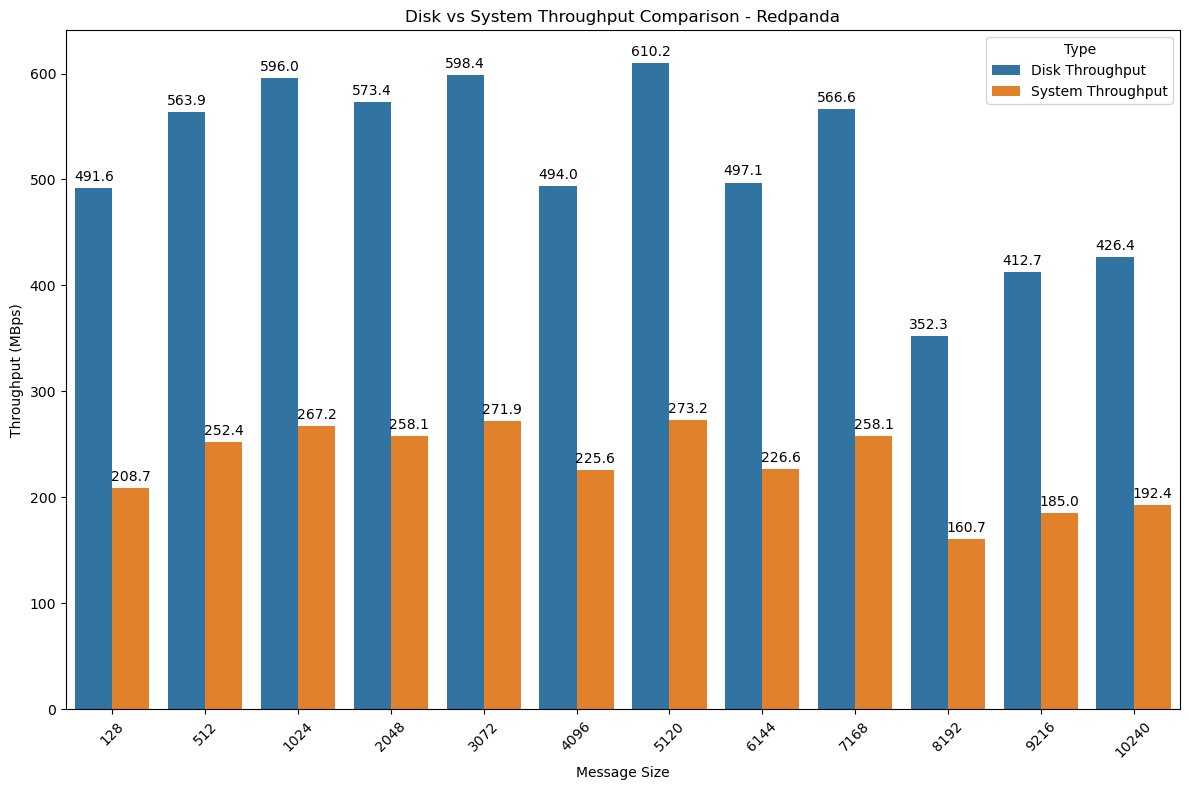

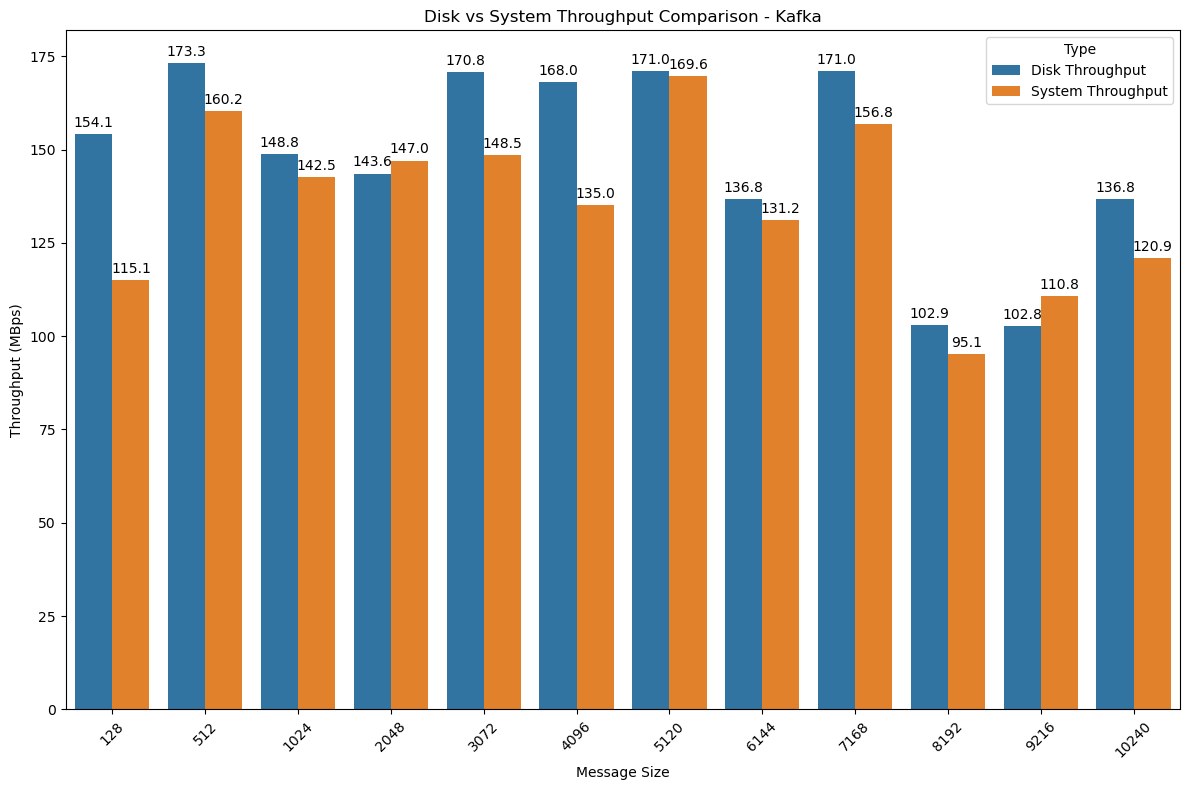

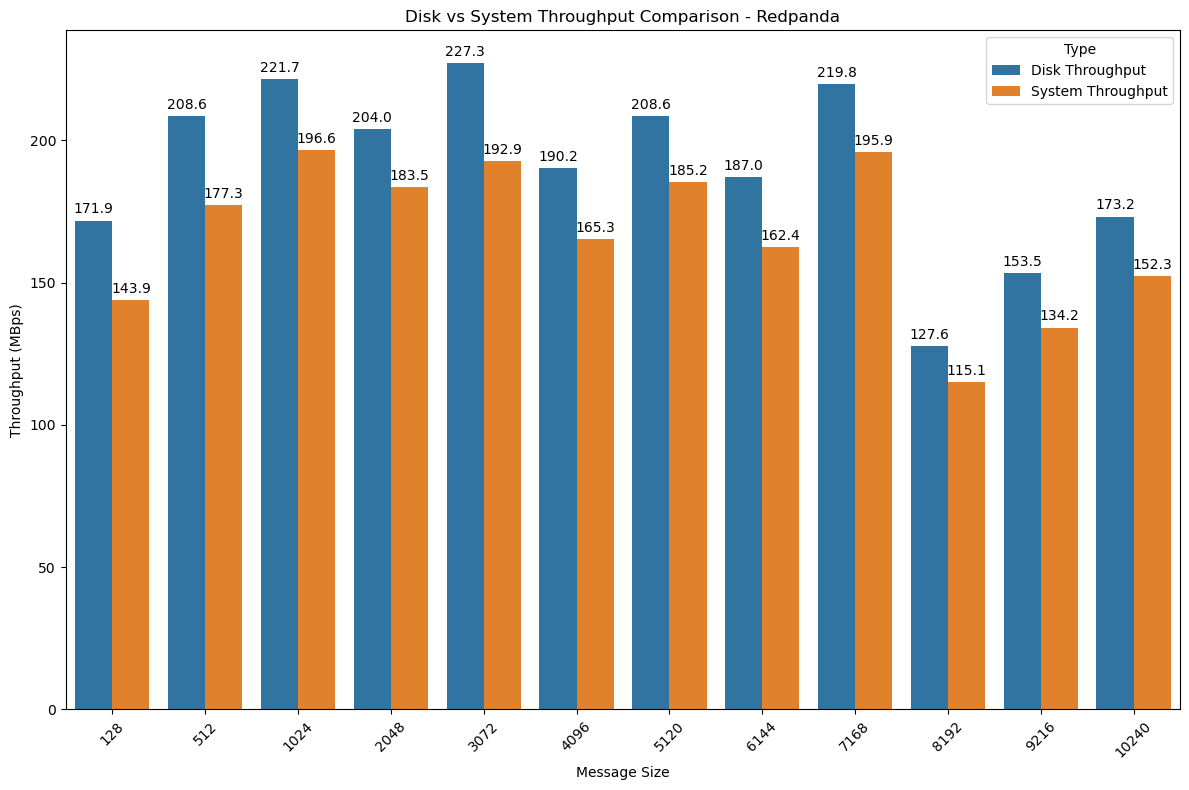

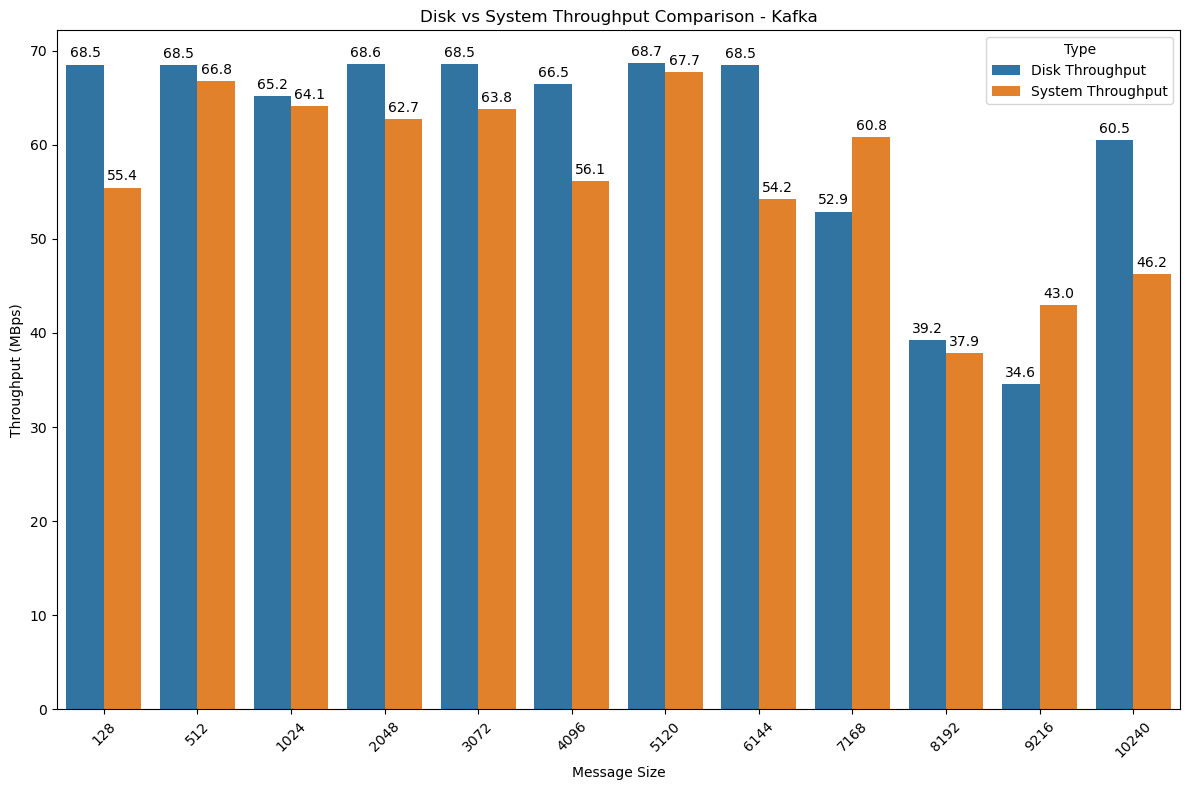

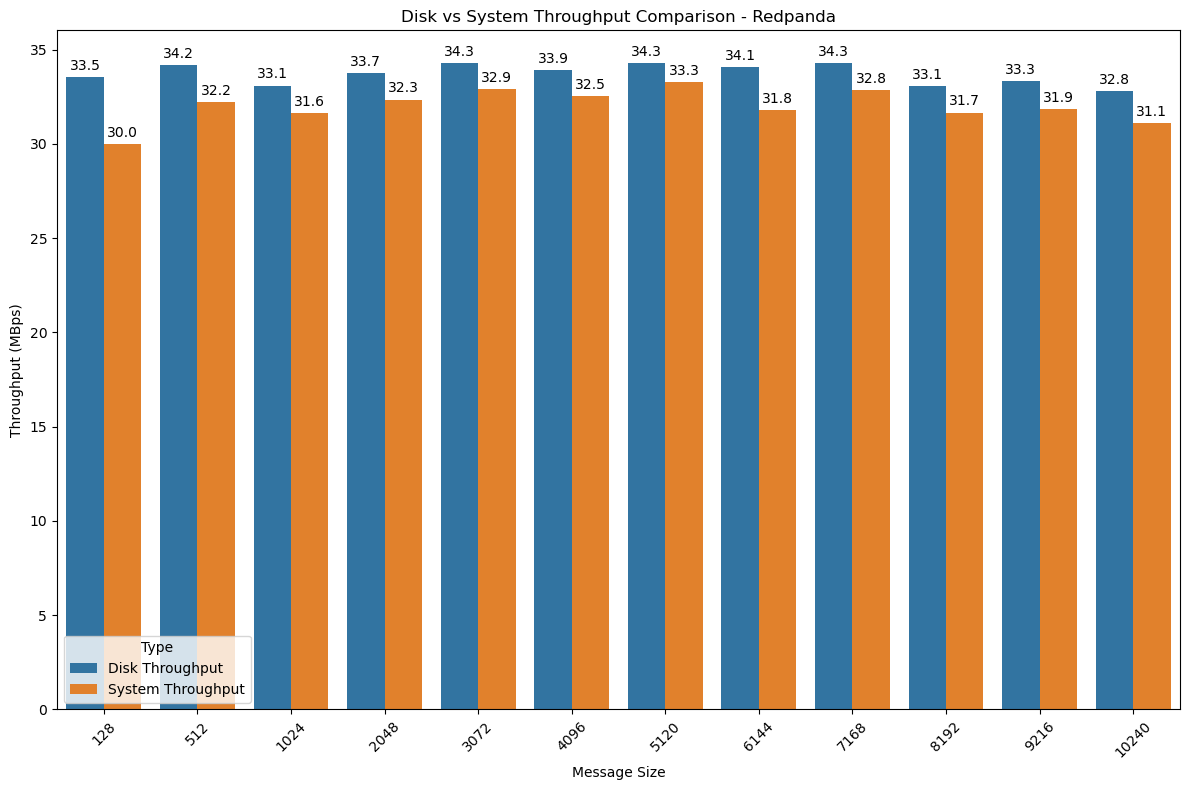

In [8]:
def throughput_comparison(data, system_name):
    # Filter data for the specific system
    system_data = data[data["exp_name"] == f"ingest-{system_name.lower()}"]
    
    # Create figure and axis
    plt.figure(figsize=(12, 8))
    
    # Reshape the data for seaborn
    plot_data = pd.DataFrame([
        {
            'Message Size': row['messageSize'],
            'Throughput (MBps)': value,
            'Type': metric
        }
        for _, row in system_data.iterrows()
        for value, metric in [
            (row['disk_throughput_MBps'], 'Disk Throughput'),
            (row['throughput_MBps'], 'System Throughput')
        ]
    ])
    
    # Create grouped bar plot
    sns.barplot(
        data=plot_data,
        x='Message Size',
        y='Throughput (MBps)',
        hue='Type',
        # palette=['skyblue', 'orange']
    )
    
    # Customize the plot
    plt.title(f'Disk vs System Throughput Comparison - {system_name}')
    plt.xticks(rotation=45)
    
    # Add value labels on top of bars
    ax = plt.gca()
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', padding=3)
    
    plt.tight_layout()
    plt.show()

# Generate plots for each system and dataset
for dataset in [ovhnvme_1, grappe_1, taurus_1]:
    throughput_comparison(dataset, "Kafka")
    throughput_comparison(dataset, "Redpanda")
